In [1]:
#######################################################################################################
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
import sys

# Get the current notebook's directory
notebook_dir = os.path.abspath('')
# Add the relative path to your Codes directory
codes_path = os.path.join(notebook_dir, "..", "Codes")
codes_path = os.path.abspath(codes_path)  # Normalize the path
# Add to path if not already there
if codes_path not in sys.path:
    sys.path.insert(1, codes_path)
from myUtils import *

MAINPATH is set to: /home/emanuele/Research/APES/FHN/


In [2]:
codes_path

'/home/emanuele/Research/APES/Forest_Human_Nexus/Codes'

# 1. Read shapefiles

In [5]:
# World shapefile
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-administrative-boundaries.shp')
gdf = gpd.read_file(shapef)
gdf = gdf.to_crs("ESRI:54009")

# Custom regions shapefiles 
shapef = os.path.join(MAINPATH, 'Data/SHAPEFILES/world-custom_regions_r.shp')
gdf1 = gpd.read_file(shapef)
gdf1 = gdf1.to_crs("ESRI:54009")

# 2. Define data

In [6]:
PATHL = os.path.join(MAINPATH, 'Data/OUTPUT/FAC/FAC_{window}_{year}.tif')
dfData = return_df(PATHL, gdf1) 

### 2.1 2020

In [7]:
dfData2020 = dfData[dfData['year']==2020].reset_index(drop=True)
dfData2020 = dfData2020.sort_values(by='median').reset_index(drop=True)
colors = dfData2020['region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)
dfData2020['median'] = dfData2020['median']*100

### Figure 1C

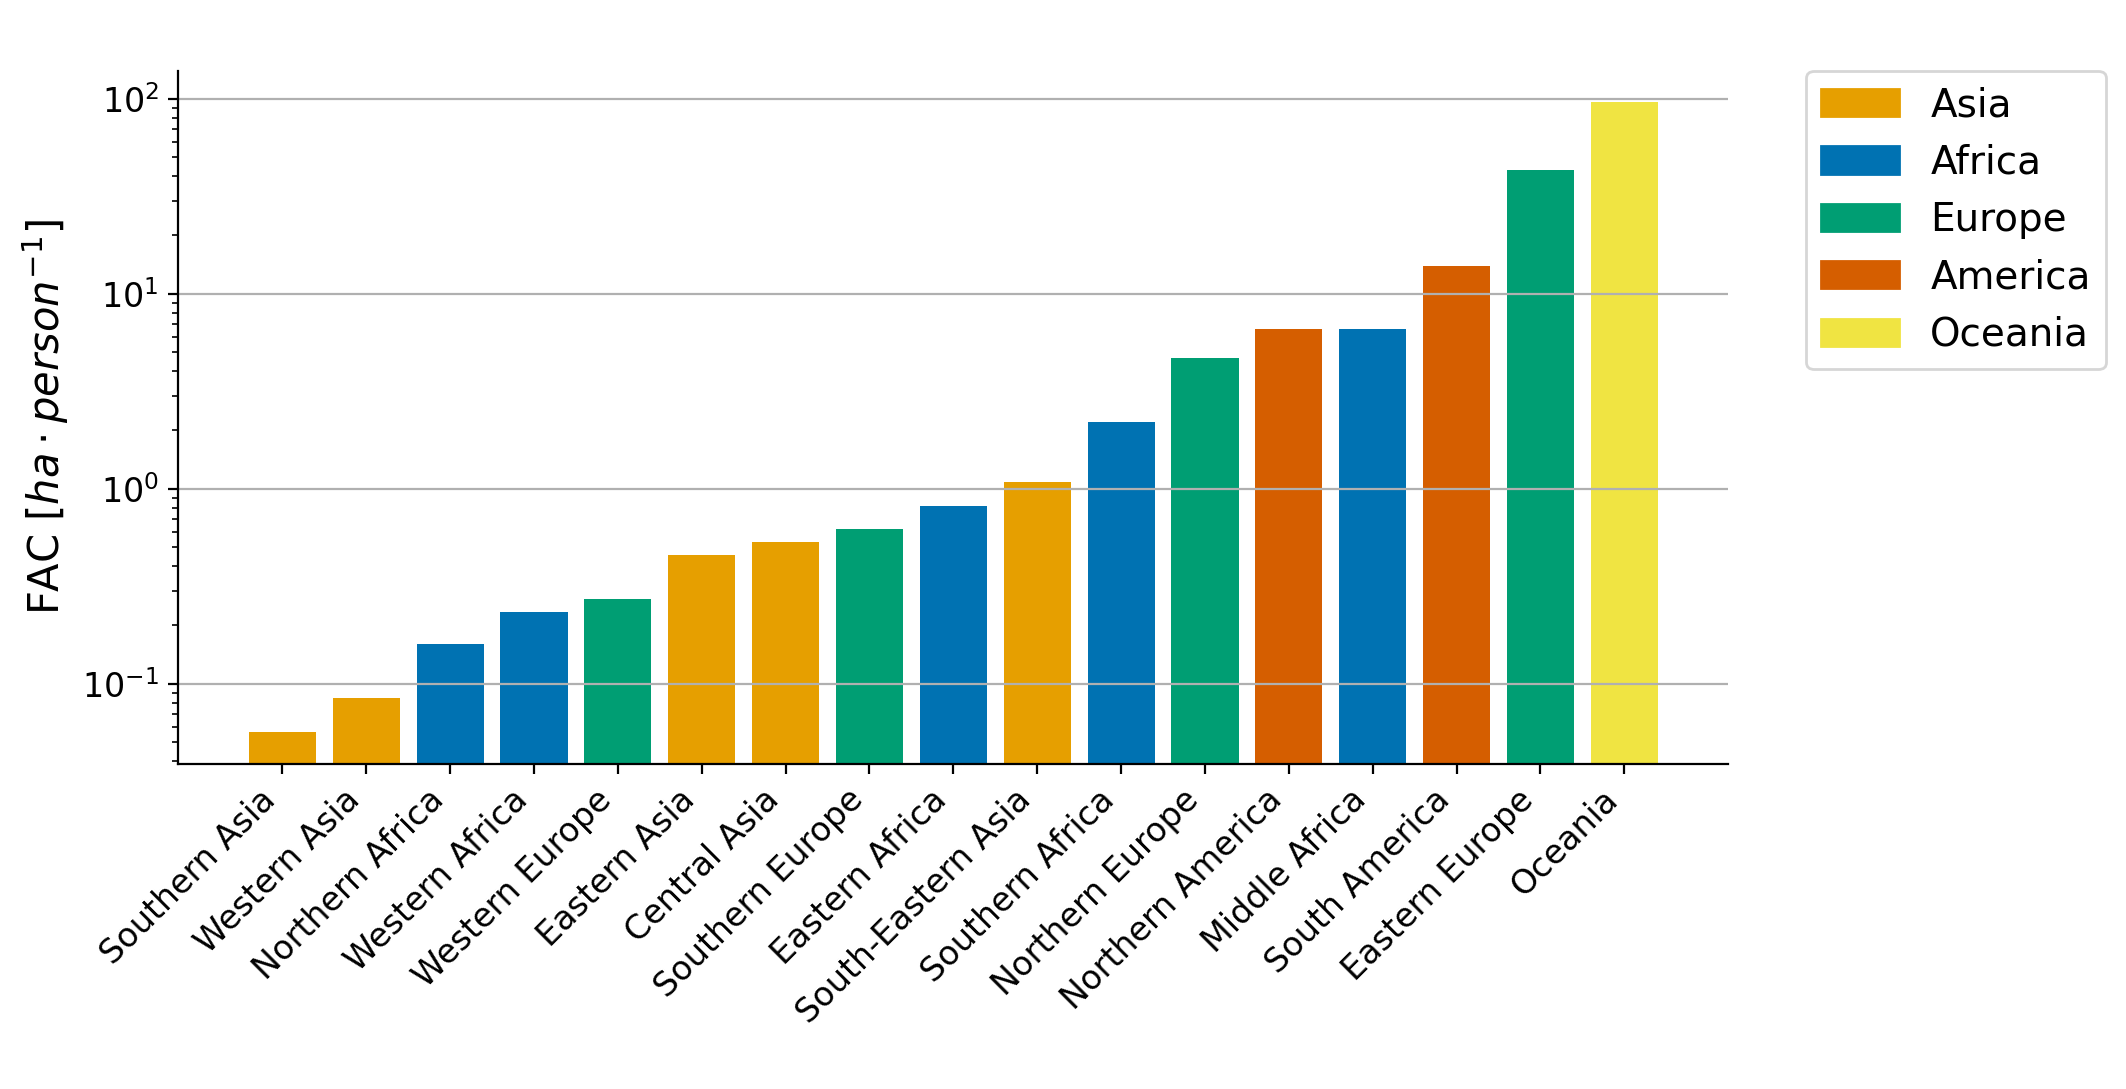

In [8]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 12)
plt.bar(dfData2020['region'], dfData2020['median'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAC '+r'$[ha \cdot person^{-1}]$', size=15)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.xticks(rotation=45, ha='right');
ax.set_yscale('log')

In [9]:
# Save Figure 1C
fout = '../Figures/Figure1C.pdf'
f.savefig(fout, dpi=300, bbox_inches='tight')

### 2.2 Relative change

In [10]:
dfData_= rel_change_df(dfData, 'median')
df5_ = dfData_.sort_values(by='relative_change').reset_index(drop=True)
colors = df5_['region'].map(REGION_TO_CONTINENT).map(CONTINENT_COLORS)

### Figure 1D

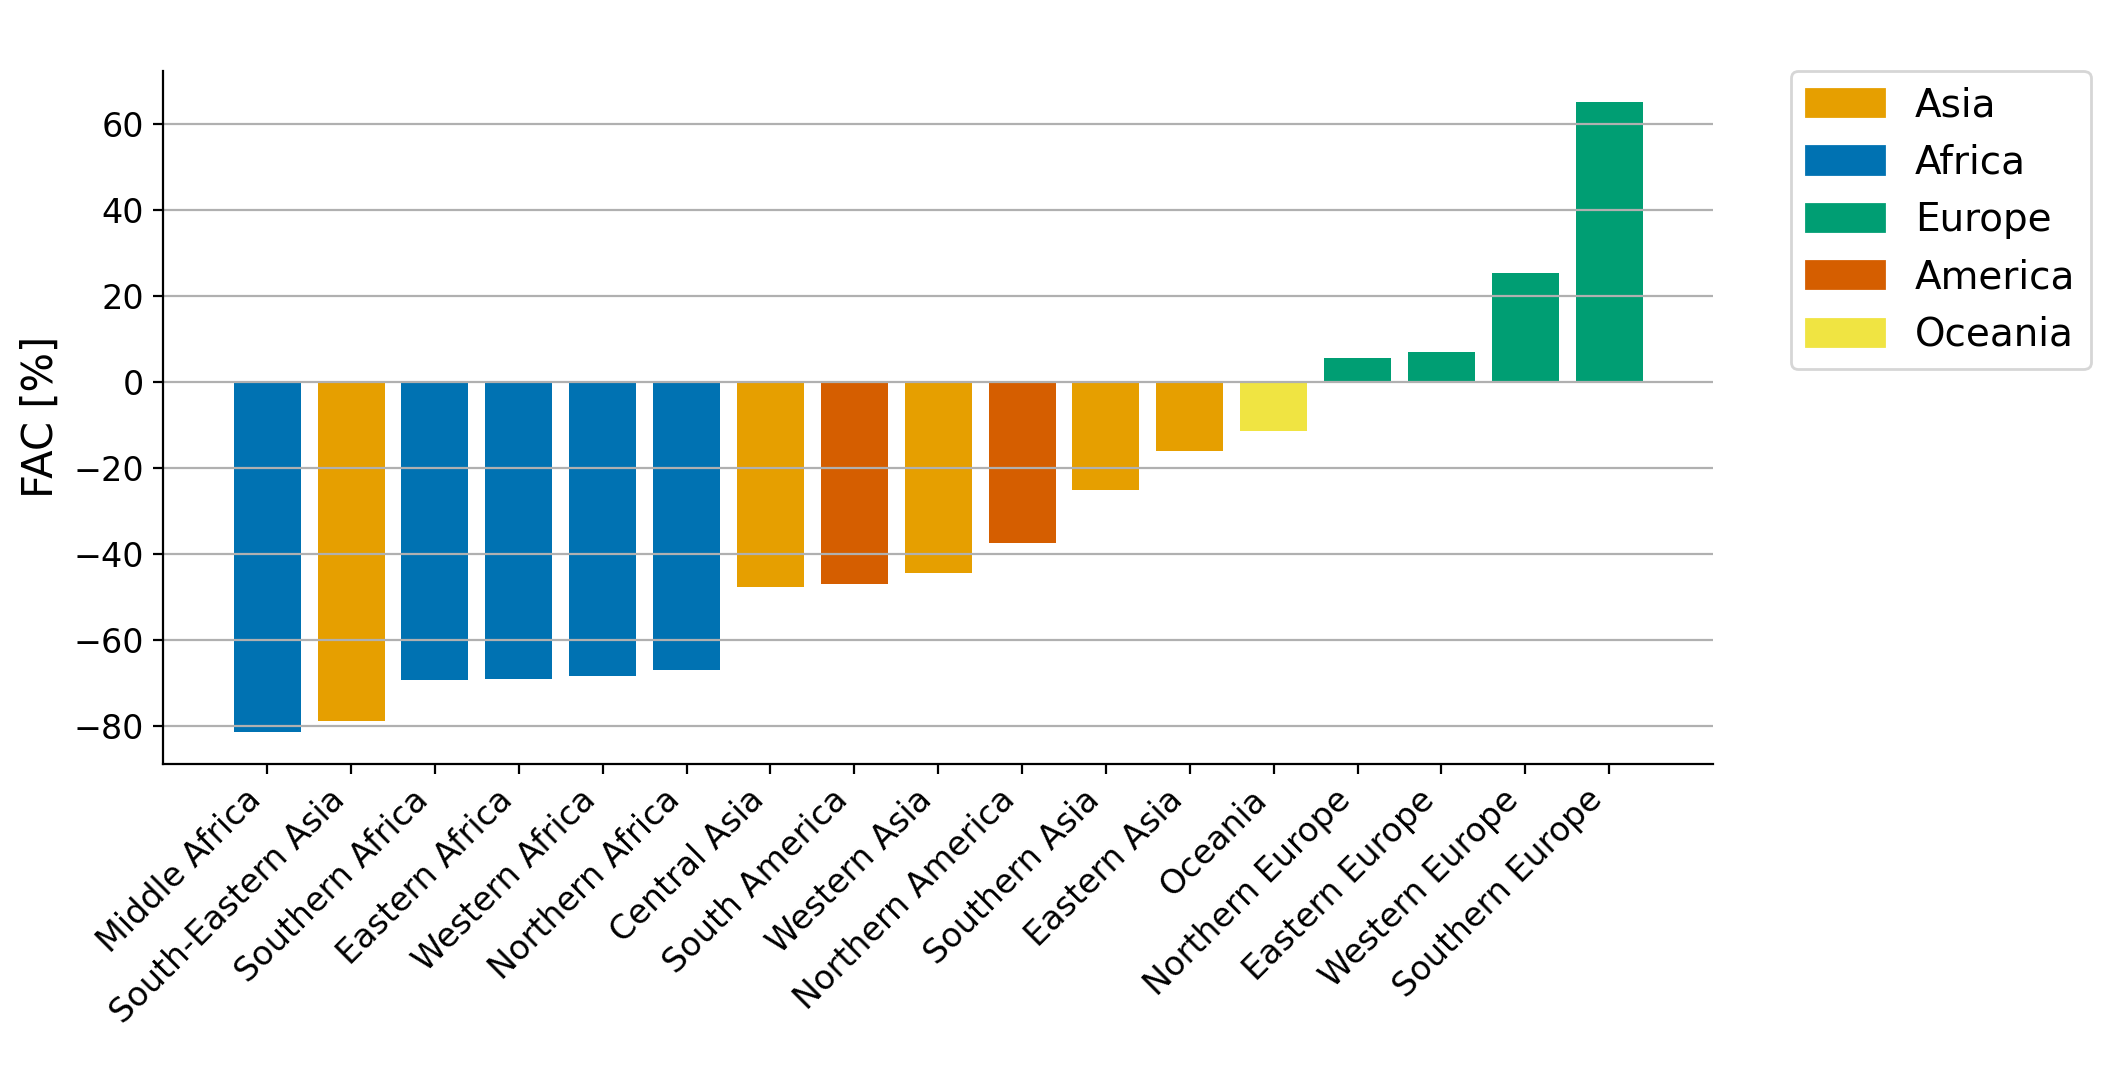

In [11]:
# Plotting the bar plot
f, ax = plt.subplots(figsize=(10, 4.5))
ax = set_font(ax, 12)
plt.bar(df5_['region'], df5_['relative_change'], color=colors)
# Adding labels and title
plt.xlabel(' ')
plt.ylabel('FAC [%]', size=15)
plt.title(' ', size=16)
plt.xticks(rotation=90, ha='right')
plt.grid(axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Creating legend patches
patches = [mpatches.Patch(color=color, label=continent) for continent, color in CONTINENT_COLORS.items()]
# Adding the legend outside the plot
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.xticks(rotation=45, ha='right');

In [12]:
# Save Figure 1D
fout = '../Figures/Figure1D.pdf'
f.savefig(fout, dpi=300, bbox_inches='tight')